# Likelihood Analysis Notebook

Use this notebook to generate the likelihood profiles from Gaia data using the Bayesian distance inferences described in  
Bailer - Jones (C. A. L. Bailer-Jones et al 2018 AJ 156 58): https://iopscience.iop.org/article/10.3847/1538-3881/aacb21.  

Specify the path variable to your own data path and run the cells. The likelihood value generation can take a while if data  
set is very large. Also pay attention to the minimum and maximum bin edge values in the 'get_likelihood_sum' function.  
Depending on the data used they might need to be tuned.  

The plots included in this notebook were generated with the spectroscopic data where using default $R_0$, $z_0$, $U_\odot$, $V_\odot$, $W_\odot$:
   * 0 < r < 15 kpc
   * -1 < z < 1 kpc

In [5]:
import gaia_tools
from gaia_tools.data_analysis import *
from gaia_tools.import_functions import import_data
from gaia_tools import transformation_constants
import matplotlib.pyplot as plt
from gaia_tools.data_plot import *
from functools import reduce

In [6]:
# DATA IMPORT
# 
path = "../../Gaia Data/MCMC_Input_0_15_-1_1.csv"
data_icrs = import_data(path = path, debug = False)

Start import...
The dimensions of the data: (rows, columns) -> (6660506, 24)
Checking indexing... 



In [7]:
# LIKELIHOOD SUM FUNCTION
'''
This function uses the Gaia data in ICRS:
1) Transforms it into a Galactocentric frame using the theta arguments given
2) Generates the covariance matrices (also transforms) and appends them to the Galactocentric data
3) Bins the data and generates a 'BinCollection' object
4) Iterates over the bins and computes a likelihood value for each
5) Sums the likelihood values over the bins
'''

def get_likelihood_sum(data_icrs, 
                       r = transformation_constants.R_0, 
                       z = transformation_constants.Z_0, 
                       Usun = transformation_constants.V_SUN[0][0],
                       Vsun = transformation_constants.V_SUN[1][0],
                       num_r_bin = 10,
                       num_z_bin = 4):
 
    start = time.time()
    theta = (r, z, Usun, Vsun, transformation_constants.V_SUN[2][0])
    
    v_sun = np.array([[theta[2]], 
                              [theta[3]], 
                              [theta[4]]])
   
    # 1
    galcen_data = get_transformed_data(data_icrs, 
                                       include_cylindrical = True, 
                                       r_0 = theta[0],
                                       v_sun = v_sun,
                                       debug = True,
                                       is_bayes = True, 
                                       is_source_included = True)
    # 2
    cov_df = gaia_tools.covariance_generation.generate_covmatrices(df = data_icrs, 
                                           df_crt = galcen_data, 
                                           transform_to_galcen = True, 
                                           transform_to_cylindrical = True,
                                           z_0 = theta[1],
                                           r_0 = theta[0],
                                           is_bayes = True,
                                           debug=True)
    
    galcen_data['cov_mat'] = cov_df['cov_mat']
    
    min_val = np.min(galcen_data.r)
    max_val = np.max(galcen_data.r)
    
    min_val_z = np.min(galcen_data.z)
    max_val_z = np.max(galcen_data.z)
    
    # 3
    bin_collection = gaia_tools.data_analysis.get_collapsed_bins(data = galcen_data, 
                                                                 theta = theta, 
                                                                 BL_r_min = min_val - 1, 
                                                                 BL_r_max = max_val + 1, 
                                                                 BL_z_min = -1200, 
                                                                 BL_z_max = 1200, 
                                                                 N_bins = (num_r_bin, num_z_bin ),
                                                                 r_drift = False, 
                                                                 debug = True)

    # Computes the MLE Mu and Sigma for each bin
    bin_collection.GetMLEParameters()
    
    # Setup likelihood array
    n = reduce(lambda x, y: x*y, bin_collection.N_bins)
    likelihood_array = np.zeros(n)

    # Keep track how many data points are used in likelihood computation
    point_count = []
    
    # 4
    for i, bin in enumerate(bin_collection.bins):
        
        likelihood_value = bin.get_bin_likelihood(debug=True)
        
        if(likelihood_value == 0):
            print(theta)
            val = 0
                    
        else:            
            #print(bin.N_points)
            point_count.append(bin.N_points)
            
            # get bin likelihood
            val = likelihood_value

        likelihood_array[i] = val
    
    print("Number of points in analysis: {0}".format(np.sum(point_count)))
    print("Bin Collection data shape: {0}".format(bin_collection.data.shape))
    
    likelihood_sum = np.sum(likelihood_array)
    
    end = time.time()
    print("Likelihood time = %s" % (end - start))
    
    return likelihood_sum, bin_collection, likelihood_array

In [12]:
# Function that generates the neccessary variables for 
# plotting the profiles

def generate_plot_vars(bin_r, bin_z, parameter):
    
    # The varied range in x-axis    
    if(parameter == "R_0"):
        x = np.linspace(6000, 12000, 10)
    elif(parameter == "U_\odot"):
        x = np.linspace(0, 50, 10)
    else:
        x = np.linspace(150, 350, 10)
    
    # The likelihood values
    y = []

    for i, item in enumerate(x):
        print(i, item)
        
        if(parameter == "R_0"):
            val = get_likelihood_sum(data_icrs, 
                                    r = item,
                                    num_r_bin = bin_r,
                                    num_z_bin = bin_z)[0]
                    
        elif(parameter == "U_\odot"):
        
            val = get_likelihood_sum(data_icrs, 
                                    Usun = item,
                                    num_r_bin = bin_r,
                                    num_z_bin = bin_z)[0]
            
        elif(parameter == "V_\odot"):
            val = get_likelihood_sum(data_icrs, 
                                    Vsun = item,
                                    num_r_bin = bin_r,
                                    num_z_bin = bin_z)[0]
        
        print("Likelihood: {0}".format(val))
        y.append(val)

    return x, y, parameter

In [19]:
# The plotting function

def generate_likelihood_plot(x, y, bin_r, bin_z, parameter, save = False):
    
    fig = plt.figure(figsize = (8,8))
    plt.plot(x, y, '-', color='blue')
    plt.title("Likelihood dependence on ${0}$".format(parameter), pad = 45, fontdict={'fontsize': 20})
    plt.suptitle(r"({0}x{1} bins)".format(bin_r, bin_z), y=0.93, fontsize=15)
    plt.grid()

    #plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    if(parameter == "R_0"):
        unit = "pc"
    else:
        unit = "km/s"
    
    plt.xlabel(r'${0}$ [{1}]'.format(parameter, unit), fontdict={'fontsize': 18}, labelpad = 25)
    plt.ylabel('Log Likelihood',fontdict={'fontsize': 18}, labelpad = 25)
    plt.subplots_adjust(left=0.2)

    title_string = "Likelihood_{0}_{1}x{2}".format(parameter, bin_r, bin_z)

    if(save):
        plt.savefig(title_string+'.png', dpi=300)

---
## R_0 Likelihood
$R_0$ is varied, rest of the parameters are fixed

0 6000.0
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 19.401355500000136 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 32.94805650000035 sec
Binning data from galactocentric input data...
Max r value in DataFrame 15059.283678688265
Time elapsed for binning data with collapsed bins: 13.924224100000174 sec
Number of points in analysis: 6660506
Bin Collection data shape: (6660506, 13)
Likelihood time = 99.97967553138733
Likelihood: -26415721.432178114
1 6666.666666666667
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 19.445068600000013 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 36.945323500000086 sec
Binning data from galactocentric input data...
Max r value in DataFrame 14943.26441641378
Time elapsed f

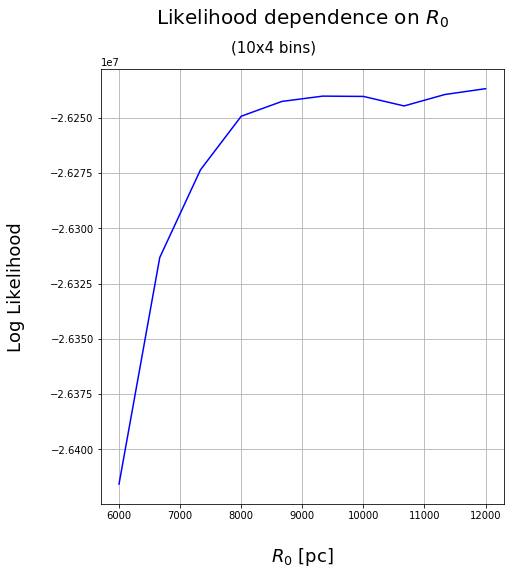

In [15]:
parameter = "R_0"

bin_r = 10
bin_z = 4

x, y, parameter = generate_plot_vars(bin_r, bin_z, parameter)

generate_likelihood_plot(x, y, bin_r, bin_z, parameter)

---
## U Likelihood
$U_\odot$ is varied, rest of the parameters are fixed

0 0.0
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 17.431163500001276 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 31.068039900001168 sec
Binning data from galactocentric input data...
Max r value in DataFrame 14999.392731321155
Time elapsed for binning data with collapsed bins: 13.434877600000618 sec
Number of points in analysis: 6660506
Bin Collection data shape: (6660506, 13)
Likelihood time = 97.59932708740234
Likelihood: -26260823.39599163
1 5.555555555555555
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 17.852093199999217 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 29.42862360000072 sec
Binning data from galactocentric input data...
Max r value in DataFrame 14999.392731321155
Time elapsed for 

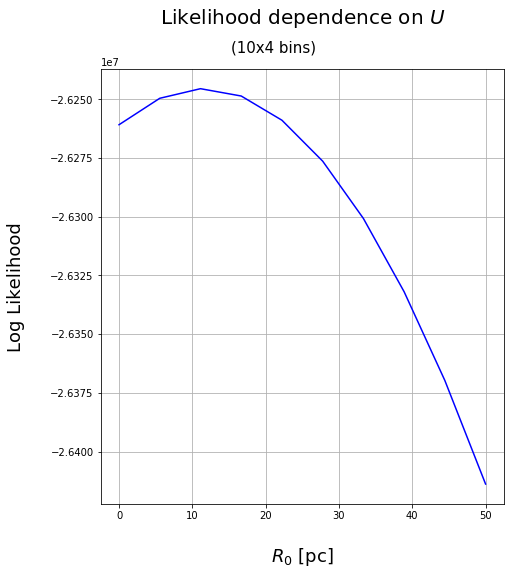

In [17]:
parameter = "U_\odot"

bin_r = 10
bin_z = 4

x, y, parameter = generate_plot_vars(bin_r, bin_z, parameter)

generate_likelihood_plot(x, y, bin_r, bin_z, parameter)

---
## V Likelihood
$V_\odot$ is varied, rest of the parameters are fixed

0 150.0
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 18.123858000000837 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 31.68350289999944 sec
Binning data from galactocentric input data...
Max r value in DataFrame 14999.392731321155
Time elapsed for binning data with collapsed bins: 17.392200700000103 sec
Number of points in analysis: 6660506
Bin Collection data shape: (6660506, 13)
Likelihood time = 111.75726175308228
Likelihood: -26327043.027482517
1 172.22222222222223
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 31.44418500000029 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 54.09190639999906 sec
Binning data from galactocentric input data...
Max r value in DataFrame 14999.392731321155
Time elapsed f

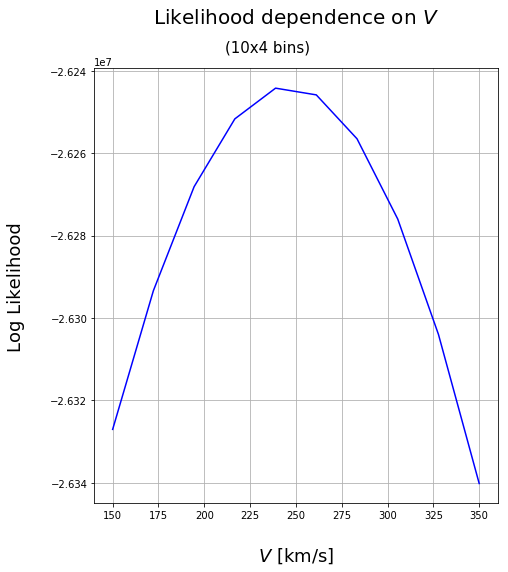

In [20]:
parameter = "V_\odot"

bin_r = 10
bin_z = 4

x, y, parameter = generate_plot_vars(bin_r, bin_z, parameter)

generate_likelihood_plot(x, y, bin_r, bin_z, parameter)

---

---